# Convolutional Neural Networks - HW 3

In [1]:
import torch, torchvision
from matplotlib import pyplot as plt

In [2]:
from torchvision import transforms
training_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    download=False,
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=32, scale=(0.85,1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="/lus/eagle/projects/datasets/CIFAR-10/",
    download=False,
    train=False,
    transform=torchvision.transforms.ToTensor()
)
import math
training_data, validation_data = torch.utils.data.random_split(training_data, [math.floor(0.8 * len(training_data)), math.floor(0.2 * len(training_data))], generator=torch.Generator().manual_seed(55))

In [3]:

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=2)

val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=2)

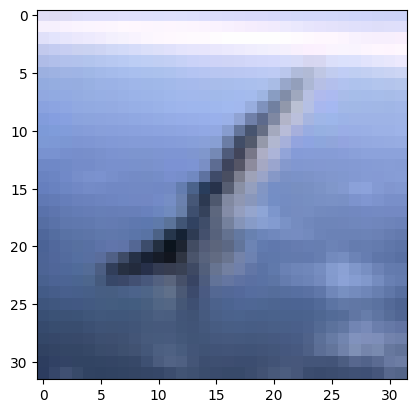

In [4]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

In [5]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl # dataloader
        self.func = func # preprocesses

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [6]:
from torch import nn

# downsampler - has downsample function and norm
class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):
        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7], 
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        # conv 1
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        # conv 2
        x = self.conv2(x)
        
        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        # conv 3
        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):

    # Classifier - conv2d, norm, etc.
    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x

In [7]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [8]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

# Homework 1:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here. [validation loss: 1.442; accuracy: 47.627%] Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

## a) Model with modified architecture

In [9]:
#n_initial_filters, n_stages, blocks_per_stage = previously, 32, 4, 2
model = Classifier(32, 6, 4).to(device=dev)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01) #previously, lr=0.001

from tqdm.notebook import tqdm

trn_acc_list=[]
trn_loss_list=[]
val_acc_list=[]
val_loss_list=[]

epochs = 30
for j in range(1,epochs+1):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training & validation loss & accuracy 
    # for training data - only once every 5 epochs (takes a while) 
    if j % 5 == 0:
        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
            acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
            print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
            trn_acc_list.append(acc)
            trn_loss_list.append(loss)
            
        with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
            acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
            print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")

            val_acc_list.append(acc_val)
            val_loss_list.append(loss_val)


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.325, accuracy: 52.718


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.354, accuracy: 50.494


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.153, accuracy: 59.417


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.190, accuracy: 57.486


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 1.228, accuracy: 57.238


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.260, accuracy: 55.489


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 1.232, accuracy: 57.887


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.279, accuracy: 56.092


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 1.073, accuracy: 62.148


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.104, accuracy: 60.206


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Train Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30: training loss: 1.044, accuracy: 64.180


Validate Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30: validation loss: 1.107, accuracy: 61.452


## b) Results

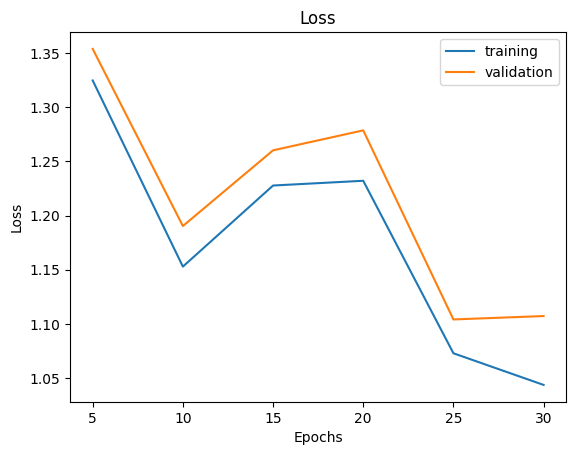

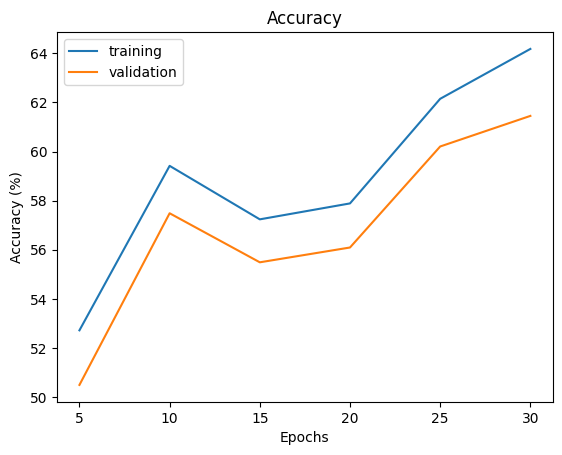

In [15]:
x_axis=[5*x for x in range(1,int(30/5)+1)]
plt.plot(x_axis,trn_loss_list, label="training")
plt.plot(x_axis, val_loss_list, label="validation")
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(x_axis, trn_acc_list, label="training")
plt.plot(x_axis, val_acc_list, label="validation")
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

Changes I made:
- I changed the number of convolutions between downsampling by changing the blocks_per_stage hyperparameter from 2 to 4. This allows for more data processing before some of the information is lost in the downsampling step.
 - I also added more total stages (of ConvNextBlocks and downsampling) by changing n_stages from 4 to 6. This expands the model's ability to learn, adding more tunable parameters.
 - Further, I used a larger learning rate (0.01 instead of 0.001) to update the weights faster and prevent the model from getting stuck in local minima.

These changes improved the validation metrics, decreasing the loss from 1.442 to 1.107 and increasing accuracy from 47.627% to 61.452%.
